![gempyterranigma](gempynigma.png)
# Transform 2022 - What is Markov chain Monte Carlo?
<a id="0"></a>
Monday - 25.04.2022


## Table of Content

* [Basic Introduction - Who is Markov and what do they do in Monte Carlo?](#1)  
* [How can we use MCMC in geosciences?](#2)
* [MCMC in Python - Introduction to PyMC3](#3)  
    * [Model definition](#3.1)  
    * [Simplest model](#3.2)  
    * [One Observation](#3.3)  
    * [Increasing the number of observations - sampling](#3.4)
* [Extending the (spatial) dimension](#4)
* [Applying this to a geological model](#5)
* [Bayesian Inference with gempy and pymc3](#6)





<a id="1"></a>
## Basic Introduction - Who is Markov and what do they do in Monte Carlo?
Markov Chain Monte Carlo, often abbreviated _MCMC_, is a method to sample the distribution of a parameter in a probabilistic space. Like Monte Carlo, it randomly samples, but unlike pure Monte Carlo, it makes an educated guess _where_ to sample (from iteration to iteration). And unlike pure Monte Carlo, these guesses get better with progressing iterations. Plus, a Markov Chain is reversible, has a memory so to say. So you can trace back your "jumps" in probability space.  

<hr>
<center>
<img src="https://images.unsplash.com/photo-1595138320174-a64d168e9970?ixlib=rb-1.2.1&ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&auto=format&fit=crop&w=2060&q=80" width="620"></img></center>
Monte Carlo photo by <a href="https://unsplash.com/@rishi_1?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText">Rishi Jhajharia</a> on <a href="https://unsplash.com/s/photos/monte-carlo?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText">Unsplash</a>
<hr>

Or to quote [Thomas Wiecki](https://twiecki.io/blog/2015/11/10/mcmc-sampling/):
<center>"Well that's easy, MCMC generates samples from the posterior distribution by constructing a reversible Markov-chain that has as its equilibrium distribution the target posterior distribution. Questions?"</center>
<br>

It should be noted, that Thomas immediately questions the usefullness of this statement. He then provides an extensive explanation of the underlying _intuition_ of MCMC, accompanied by a lot of Python code! https://twiecki.io/blog/2015/11/10/mcmc-sampling/



MCMC boils down to be a collection of method helping to do bayesian inference, thus based on Bayes Theorem:  

$$P(\theta | x) = \frac{P(x|\theta) P(\theta)}{P(x)} $$  

* $P(\theta | x)$ is the Posterior  
* $P(x)$ is the Prior  
* $P(x | \theta)$ is the Likelihood  
* $P(x)$ the evidence  

As calculating the posterior in this form is most likely not possible in real-world problems. If one could sample from the posterior, one might approximate it with Monte Carlo. But in order to sample directly from the posterior, one would need to invert Bayes Theorem.  

The solution to this problem is, when we cannot draw MC (in this case Monte Carlo) samples from the distribution directly, we let an MC (now a Markov Chain) do it for us. [1]


<a id="2"></a>
## How can we use MCMC in geosciences?  

Applications of MCMC in geosciences are manifold. Simply, because knowing the `evidence` is almost never the case. Thus, MCMC can be used for estimating a parameter's posterior without knowing the `evidence`, also called the normalizing constant [2]. Most often, this is done by having some observations to begin with and formulating a forward problem. Parameters of this problem are assigned to distributions. The forward problem is then solved iteratively with parameter values sampled from the distributions until a set of parameter values is reached, whose equilibrium distribution is similar to the posterior.  

Among others, some applications are:  

* Location of earthquake hypocenters  
* Uncertainty quantification in geological modeling  
* Geochronology  
* Inferring environmental variables (sea-level, sediment supply, ...) from stratigraphic piles  
* _and many more_  



<a id="3"></a>
## MCMC in Python - Introduction to PyMC3

To perform Bayesian inference via MCMC, PyMC3 was developed. It is an open source framework for probabilistic programming building on Theano (for AD and speed increase). PyMC3 is quite high-level, meaning its syntax is "close to the natural syntax statisticians use to describe models" [3]. In addition to a quite high-level and approachable syntax, PyMC3 features different kinds of sampling algorithms in MCMC, e.g. NUTS or HMC.

In [1]:
 # These two lines are necessary only if GemPy is not installed
import sys, os
sys.path.insert(0, "../../../gempy/")
os.environ["THEANO_FLAGS"] = "mode=FAST_RUN,device=cpu"

# Importing GemPy
import gempy as gp

# Embedding matplotlib figures in the notebooks
%matplotlib inline

# Importing auxiliary libraries
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm
import arviz as az

from gempy.bayesian import plot_posterior as pp
from gempy.bayesian.plot_posterior import default_blue, default_red
import seaborn as sns
from importlib import reload
from matplotlib.ticker import StrMethodFormatter

sns.set_style('ticks')
sns.set_context('talk')

No module named 'osgeo'


WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


<a id="3.1"></a>
### Model definition
Generally, models represent an abstraction of reality to answer a specific question, to fulfill a certain purpose, or to _simulate_ (mimic) a proces or multiple processes. What models share is the aspiration to be as realistic as possible, so they can be used for prognoses and to better understand a real-world system.

Fitting of these models to acquired measurements or observations is called calibration and a standard procedure for improving a models reliability (**to answer the question it was designed for**). 

Models can also be seen as a general descriptor of correlation of observations in multiple dimensions. Complex systems with generally sparse data coverage (e.g. the subsurface) are difficult to reliably encode from the real-world in the numerical abstraction, i.e. a computational model.

In a probabilistic framework, a model is a framework of different input distributions, which, as an output, has another probability distribution. 


In the notebook, we will work with a couple of observations (`y_obs`, `y_obs_list`) of a property encapsulated in a model. Depending on its purpose, these may be anything from petrophysical properties of rocks (density, thermal conductivity, porosity, ... you name it), to thickness of geological layers, and honestly any model property.

In [2]:
np.random.seed(4003)
y_obs = [2.12]
y_obs_list = [2.12, 2.06, 2.08, 2.05, 2.08, 2.09,
              2.19, 2.07, 2.16, 2.11, 2.13, 1.92]

Those observations are used for generating Distributions (~ probabilistic models) in [PyMC3](https://docs.pymc.io/en/v3/) which we encapsulate in the following function:

<a id="3.2"></a>
### Simplest probabilistic modeling

Consider the simplest probabilistic model where the output $y$ of a model is a distribution. Let's assume, $y$ is a normal distribution, described by a mean $\mu$ and a standard deviation $\sigma$. Usually, those are considered scalar values, but they themselves can be distributions. This will yield a change of the width and position of the normal distribution $y$ with each iteration.

As a reminder, a normal distribution is defined as: 

$$ y = \frac{1}{\sigma \sqrt{2\pi}} \, e^{-\frac{(x - \mu)^2}{2 \sigma ^2}} $$

* $\mu$ mean (Normal distribution)  
* $\sigma$ standard deviation (Gamma distribution, Gamma log-likelihood)  
* $y$ Normal distribution

With this constructed model, we are able to infer which model parameters will fit observations better by _optimizing_ for regions with high density mass. In addition (or even substituting) to data observations, informative values like prior simulations or expert knowledge can pour into the construction of the first $y$ distribution, the _prior_.  

There isn't a limitation about how "informative" a prior can or must be. Depending on the variance of the model's parameters and on the number of observations, a model will be more _prior driven_ or _data driven_.

Let's set up a `pymc3` model using the `y_obs_list` from above as observations and with $\mu$ and $\sigma$ being:  
* $\mu$ = Normal distribution with mean 2.08 and standard deviation 0.07  
* $\sigma$ = Gamma distribution with $\alpha$ (shape parameter) 0.3 and $\beta$ (rate parameter) 3  
* $y$ = Normal distribution with $\mu$, $\sigma$ and `y_obs_list` as observations

A [Gamma distribution](https://docs.pymc.io/en/latest/api/distributions/generated/pymc.Gamma.html) can also be expressed by mean and standard deviation with $\alpha = \frac{\mu^2}{\sigma^2}$ and $\beta = \frac{\mu}{\sigma^2}$

In [3]:
with pm.Model() as model:
    mu = pm.Normal('$\mu$', 2.08, .07)
    sigma = pm.Gamma('$\sigma$', 0.3, 3)
    y = pm.Normal('$y$', mu, sigma, observed=y_obs_list)

In [4]:
mu

$\mu$

In [5]:
sigma

$\sigma$

In [6]:
y

$y$

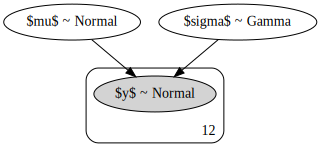

In [7]:
pm.model_to_graphviz(model)

<a id='3.3'></a>
###  One Observation:

Before diving in sampling, let's look at a model, where we have a single observation to sample the posterior from a prior with a normal distribution for $\mu$ and a gamma distribution for $\sigma$: 

In [10]:
with pm.Model() as model_s:
            mu = pm.Normal('$\mu$', 2.08, .07)
            sigma = pm.Gamma('$\sigma$', 0.3, 3)
            y = pm.Normal('$y$', mu, sigma, observed=y_obs)

with model_s:
    prior = pm.sample_prior_predictive(300)
    trace = pm.sample(300, discard_tuned_samples=False)
    post = pm.sample_posterior_predictive(trace)

data = az.from_pymc3(trace=trace,
                     prior=prior,
                     posterior_predictive=post)

Only 300 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [$\sigma$, $\mu$]
Sampling 4 chains, 123 divergences: 100%|██████████████████████████████████████| 3200/3200 [00:05<00:00, 624.04draws/s]
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
There were 30 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6643314889753613, but should be close to 0.8. Try to increase the number of tuning steps.
There were 42 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.597130734275315, but should be close to 0.8. Try to increase the number of tuning steps.
There were 33 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.694464848

C:\Users\Simon\Anaconda3\envs\gempy_mcmc_py38\lib\site-packages\arviz\stats\stats.py:337: UserWarning: hpd will be deprecated Please replace hdi
  warnings.warn(


(1.7, 2.4)

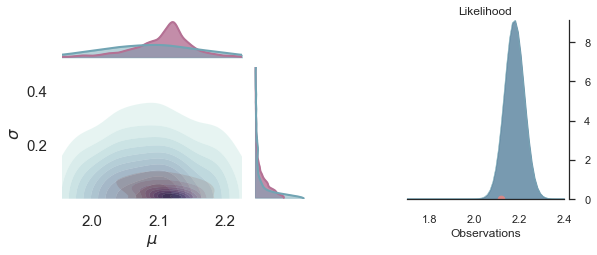

In [11]:
%matplotlib inline
reload(pp)
p = pp.PlotPosterior(data)

p.create_figure(figsize=(9,5), joyplot=False, marginal=True, likelihood=True)
p.plot_marginal(var_names = ['$\mu$', '$\sigma$'],
                plot_trace=False, credible_interval=.93, kind='kde')

p.plot_normal_likelihood('$\mu$', '$\sigma$', '$y$', iteration=-1, hide_lines=True)
p.likelihood_axes.set_xlim(1.70,2.40)



<a id="3.4"></a>
## Increasing the number of observations - sampling
We previously mentioned that we can optimize this model to better fit observations. For this, we generate a prior from the model we just created. 
In the following, samples are iteratively drawn and evaluated to form the posterior. This generates what is called a "trace". A predictive Posterior distribution is then generated from said trace.

In [12]:
with model:
    prior = pm.sample_prior_predictive(1000)
    trace = pm.sample(1000, discard_tuned_samples=False)
    post = pm.sample_posterior_predictive(trace)

data = az.from_pymc3(trace=trace,
                     prior=prior,
                     posterior_predictive=post)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [$\sigma$, $\mu$]
100%|████████████████████████████████████████████████████████████████████████████| 6000/6000 [00:03<00:00, 1540.08it/s]


#### Raw observations:
The behaviour of this chain is controlled by the observations we fed into the model. Let's have a look again at the observations:

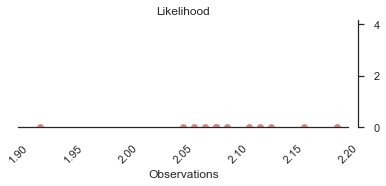

In [13]:

reload(pp)
p = pp.PlotPosterior(data)
p.create_figure(figsize=(9,3), joyplot=False, marginal=False)
p.plot_normal_likelihood('$\mu$', '$\sigma$', '$y$', iteration=-1, hide_bell=True)
#p.likelihood_axes.set_xlabel('Observations')
p.likelihood_axes.set_xlim(1.90,2.2)
p.likelihood_axes.xaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}'))
for tick in p.likelihood_axes.get_xticklabels():
    tick.set_rotation(45)


The bulk of observations is between 2.05 and 2.15, one observation at the lower end with 1.92.

#### Final inference  

Now let's plot the inferred posterior distribution and the observations:

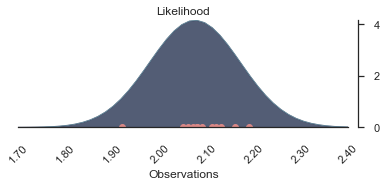

In [14]:
p = pp.PlotPosterior(data)
p.create_figure(figsize=(9,3), joyplot=False, marginal=False)
p.plot_normal_likelihood('$\mu$', '$\sigma$', '$y$', iteration=-1, hide_lines=True)
#p.likelihood_axes.set_xlabel('Observations')
p.likelihood_axes.set_xlim(1.70,2.40)
p.likelihood_axes.xaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}'))
for tick in p.likelihood_axes.get_xticklabels():
    tick.set_rotation(45)


### Joyplot

Just plotting the posterior does not convey the underlying process. Attached to GemPy, and used for its stochastic capabilities, visualization methods for drawing distributions were written. More specifically, we use joyplots for showing the change of the distribution (more precisely its mean and its standard deviation) with the progressing chaing:

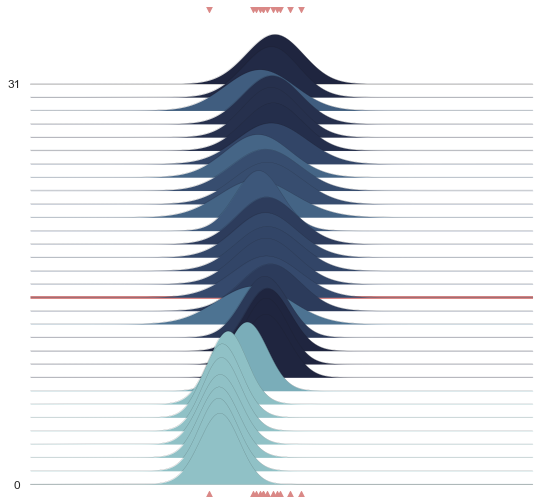

In [15]:
%matplotlib inline
reload(pp)
p = pp.PlotPosterior(data)

p.create_figure(figsize=(9,9), joyplot=True, marginal=False, likelihood=False, n_samples= 31)
p.plot_joy(('$\mu$', '$\sigma$'), '$y$', iteration=14);

### Join probability

In [ ]:
%matplotlib inline
reload(pp)
p = pp.PlotPosterior(data)

p.create_figure(figsize=(9,5), joyplot=False, marginal=True, likelihood=True)
p.plot_marginal(var_names = ['$\mu$', '$\sigma$'],
                plot_trace=False, credible_interval=.93, kind='kde')

p.plot_normal_likelihood('$\mu$', '$\sigma$', '$y$', iteration=-1, hide_lines=True)
p.likelihood_axes.set_xlim(1.70,2.40)


C:\Users\Simon\Anaconda3\envs\gempy_mcmc_py38\lib\site-packages\arviz\stats\stats.py:337: UserWarning: hpd will be deprecated Please replace hdi
  warnings.warn(


(1.7, 2.4)

### Full plot

C:\Users\Simon\Anaconda3\envs\gempy_mcmc_py38\lib\site-packages\arviz\stats\stats.py:337: UserWarning: hpd will be deprecated Please replace hdi
  warnings.warn(


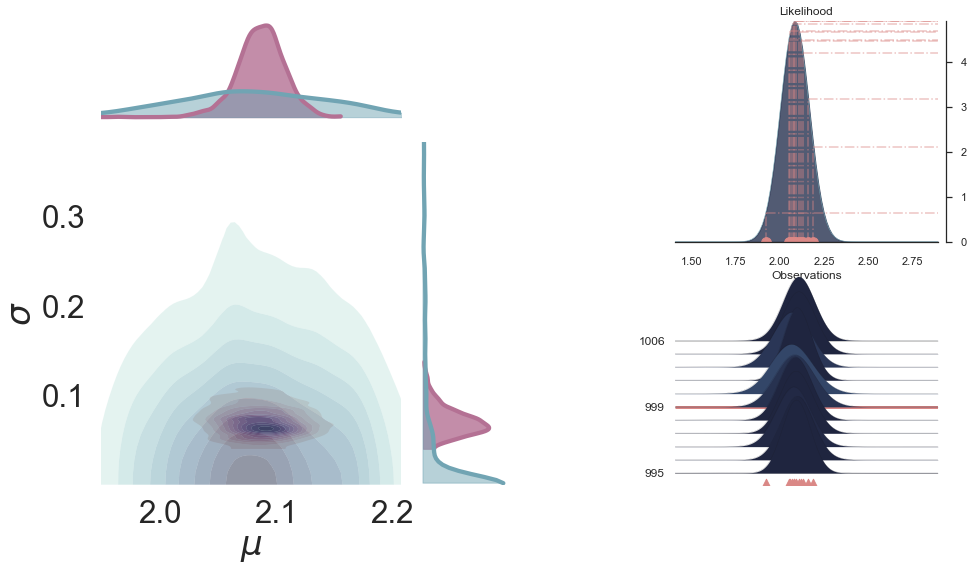

In [16]:
%matplotlib inline
reload(pp)
p = pp.PlotPosterior(data)

p.create_figure(figsize=(15,13), joyplot=True, marginal=True, likelihood=True, n_samples= 11)

p.plot_posterior(['$\mu$', '$\sigma$'], ['$\mu$', '$\sigma$'], '$y$', 1000,
                marginal_kwargs={'plot_trace':False, 'credible_interval':.93, 'kind':'kde'})



## Extending the Dimensions

In [3]:
y_obs = [2.12]
y_obs_list = [2.12, 2.06, 2.08, 2.05, 2.08, 2.09,
              2.19, 2.07, 2.16, 2.11, 2.13, 1.92]

np.random.seed(4003)

In [4]:
with pm.Model() as model:
    mu_top = pm.Normal('$\mu_{top}$', 3.05, .2) 
    sigma_top= pm.Gamma('$\sigma_{top}$', 0.3, 3)
    y_top = pm.Normal('y_{top}', mu=mu_top, sd=sigma_top, observed=[3.02])
    
    mu_bottom = pm.Normal('$\mu_{bottom}$', 1.02, .2) 
    sigma_bottom = pm.Gamma('$\sigma_{bottom}$', 0.3, 3)
    y_bottom = pm.Normal('y_{bottom}', mu=mu_bottom, sd=sigma_bottom, observed=[1.02])

    mu_t = pm.Deterministic('$\mu_{thickness}$', mu_top-mu_bottom)
    sigma_thick = pm.Gamma('$\sigma_{thickness}$', 0.3, 3)
    y = pm.Normal('y_{thickness}', mu=mu_t, sd=sigma_thick, observed=y_obs_list)


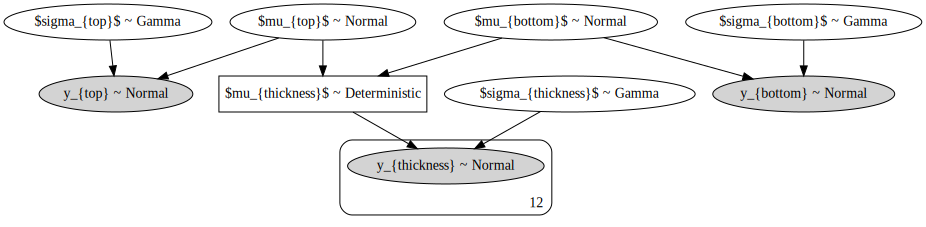

In [5]:
pm.model_to_graphviz(model)

In [6]:
with model:
    prior = pm.sample_prior_predictive(200)
    trace = pm.sample(200,  discard_tuned_samples=False)
    post = pm.sample_posterior_predictive(trace)

Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [$\sigma_{thickness}$, $\sigma_{bottom}$, $\mu_{bottom}$, $\sigma_{top}$, $\mu_{top}$]
Sampling 4 chains, 120 divergences: 100%|██████████████████████████████████████| 2800/2800 [00:08<00:00, 332.75draws/s]
There were 28 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6349075271943637, but should be close to 0.8. Try to increase the number of tuning steps.
There were 44 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.40091906660338783, but should be close to 0.8. Try to increase the number of tuning steps.
There were 36 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6190989674281617, but 

In [7]:
data = az.from_pymc3(trace=trace,
                     prior=prior,
                     posterior_predictive=post)

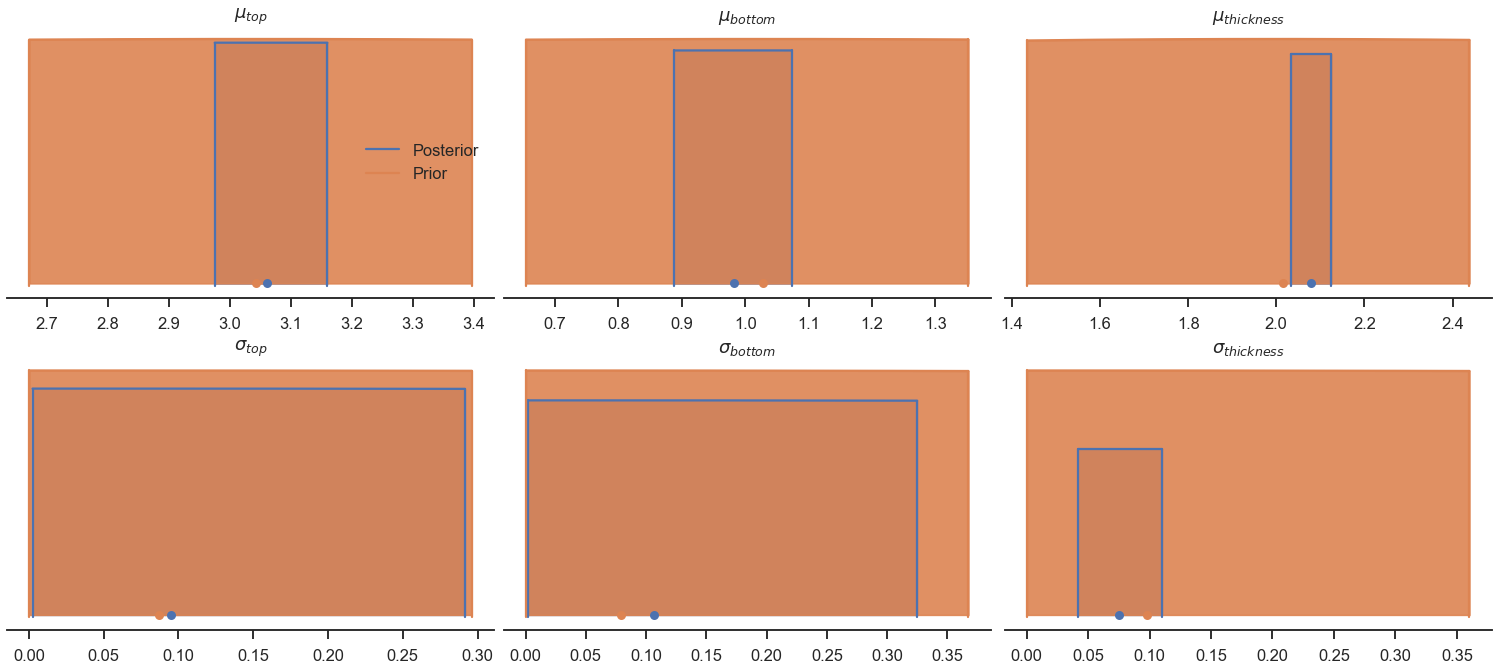

In [8]:
az.plot_density([data, data.prior], shade=.9, data_labels=["Posterior", "Prior"],
        var_names=[
             '$\\mu_{top}$',
             '$\\mu_{bottom}$',
             '$\\mu_{thickness}$',
             '$\\sigma_{top}$',
             '$\\sigma_{bottom}$',            
             '$\\sigma_{thickness}$'
        ],bw=5);

C:\Users\Simon\Anaconda3\envs\gempy_mcmc_py38\lib\site-packages\arviz\stats\stats.py:337: UserWarning: hpd will be deprecated Please replace hdi
  warnings.warn(


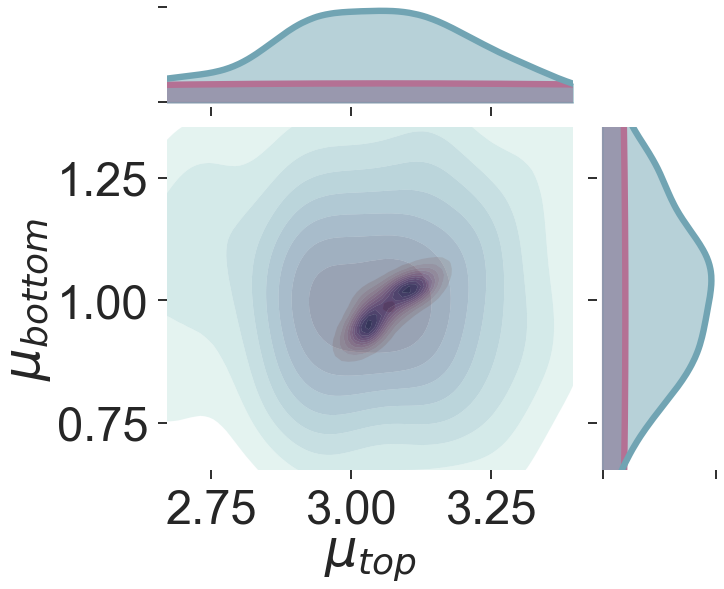

In [10]:
%matplotlib inline
p = pp.PlotPosterior(data)

p.create_figure(figsize=(15,13), joyplot=False, marginal=True, likelihood=False)
p.plot_marginal(var_names = ['$\\mu_{top}$', '$\\mu_{bottom}$'],
                plot_trace=False, credible_interval=.70, kind='kde',
                marginal_kwargs={"bw":1}
               );

<IPython.core.display.Javascript object>


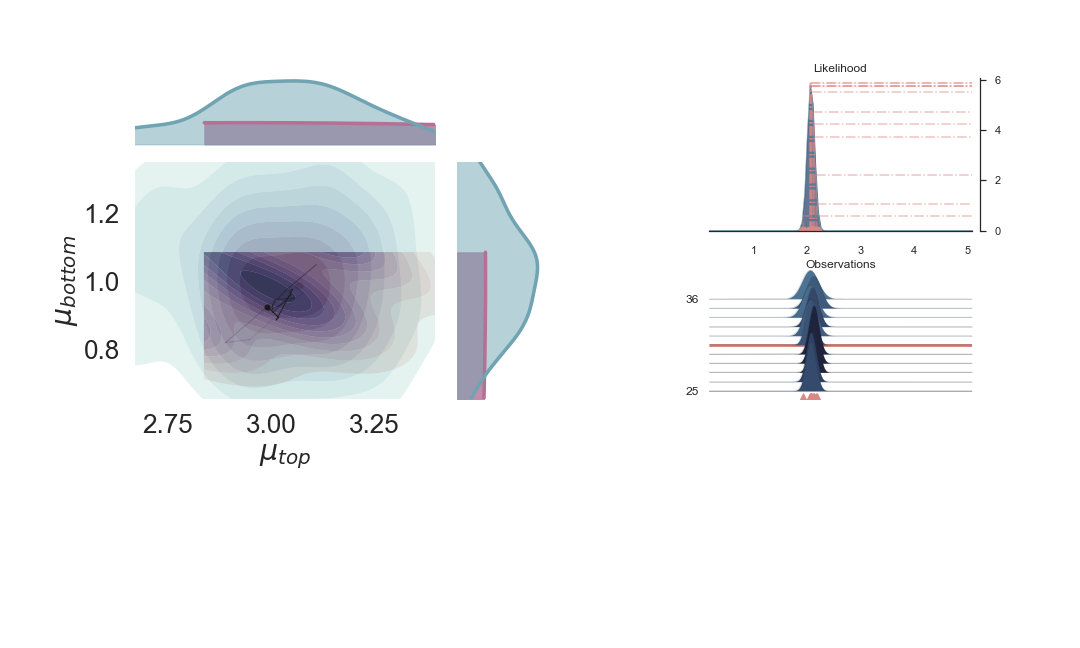

interactive(children=(IntSlider(value=0, continuous_update=False, description='iteration', max=30), Output()),…

In [27]:
%matplotlib notebook
from importlib import reload
reload(pp)
p = pp.PlotPosterior(data)
p.create_figure(figsize=(15,9), joyplot=True)

def change_iteration(iteration):
    p.plot_posterior([ '$\\mu_{top}$', '$\\mu_{bottom}$'],
                     ['$\mu_{thickness}$', '$\sigma_{thickness}$'],
                     'y_{thickness}', iteration, marginal_kwargs={"credible_interval":0.94,
                                                                 'marginal_kwargs':{"bw":1},
                                                                 'joint_kwargs':{"bw":1}})

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

interact(change_iteration, iteration=widgets.IntSlider(min=0, max=30, step=1, value=0, continuous_update=False));

<a id="5"></a>
## Applying this to geological modeling

In the previous example we assume constant thickness to be able to reduce the problem to one dimension. This keeps the probabilistic model fairly simple since we do not need to deel with complex geometric structures. Unfortunaly, geology is all about dealing with complex three dimensional structures. In the moment data spread across the physical space, the probabilistic model will have to expand to relate data from different locations. In other words, the model will need to include either interpolations, regressions or some other sort of spatial functions. In this paper, we use an advance universal co-kriging interpolator. Further implications of using this method will be discuss below but for this lets treat is a simple spatial interpolation in order to keep the focus on the constraction of the probabilistic model.

In [11]:
geo_model = gp.create_model('2-layers')
gp.init_data(geo_model, extent=[0, 12e3, -2e3, 2e3, 0, 4e3], resolution=[500, 1, 500])

Active grids: ['regular']


2-layers  2022-04-21 15:13

In [12]:
geo_model.add_surfaces('surface 1')
geo_model.add_surfaces('surface 2')
geo_model.add_surfaces('basement')
dz = geo_model.grid.regular_grid.dz

In [13]:
geo_model.add_surface_values([dz, 0, 0], 'dz')
geo_model.add_surface_values([2.6, 2.4, 3.2], 'density')

,surface,series,order_surfaces,color,id,dz,density
0,surface 1,Default series,1,#015482,1,8.000000,2.600000
1,surface 2,Default series,2,#9f0052,2,0.000000,2.400000
2,basement,Default series,3,#ffbe00,3,0.000000,3.200000


In [14]:
geo_model.add_surface_points(3e3, 0, 3.05e3, 'surface 1')
geo_model.add_surface_points(9e3, 0, 3.05e3, 'surface 1')

geo_model.add_surface_points(3e3, 0, 1.02e3, 'surface 2')
geo_model.add_surface_points(9e3, 0, 1.02e3, 'surface 2')

geo_model.add_orientations(  6e3, 0, 4e3, 'surface 1', [0,0,1])

,X,Y,Z,G_x,G_y,G_z,smooth,surface
0,6000.0,0.0,4000.0,0.0,0.0,1.0,0.01,surface 1


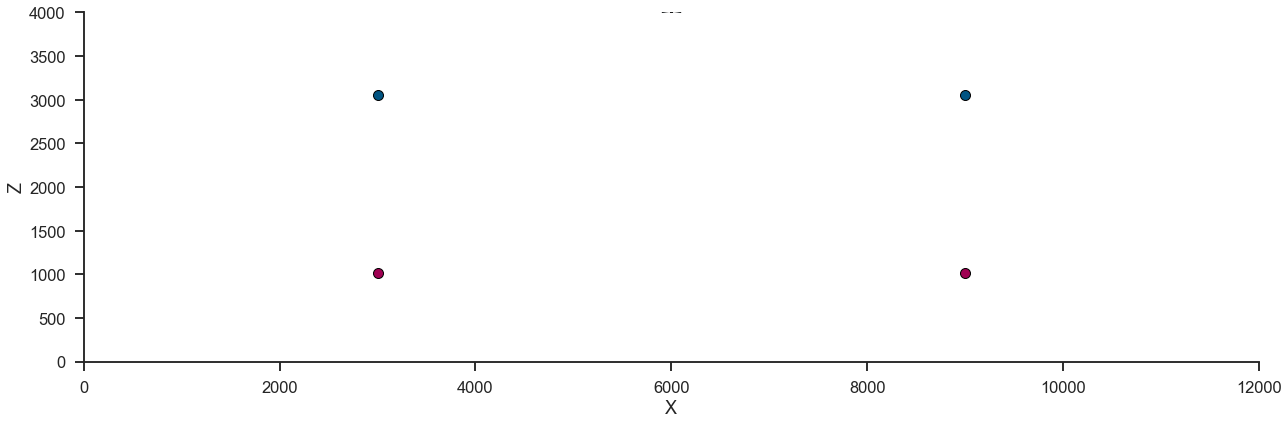

In [15]:
gp._plot.plot_data(geo_model)

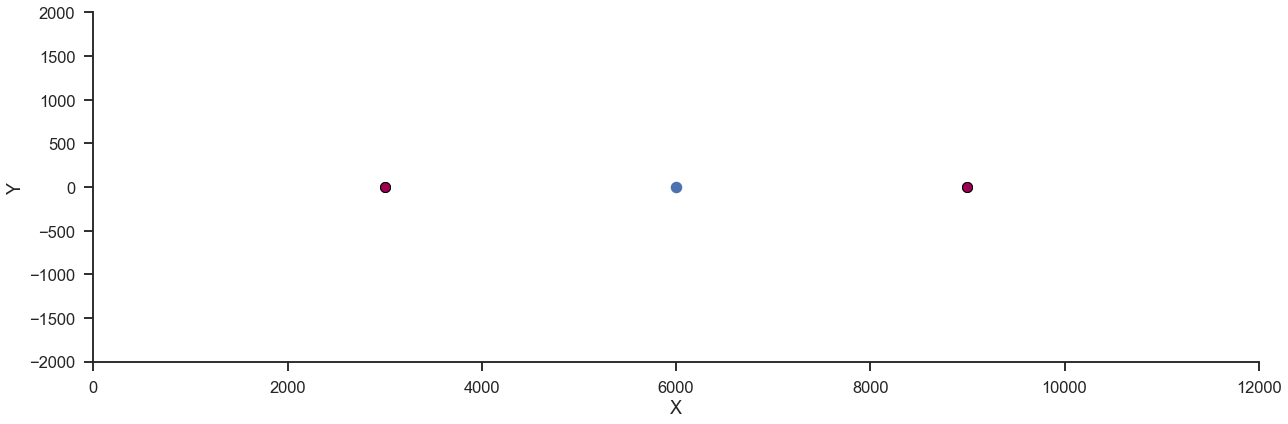

In [16]:
device_loc = np.array([[6e3, 0, 4e3]])

gp._plot.plot_data(geo_model, direction='z')
plt.scatter(device_loc[:,0], device_loc[:, 1], s=100)

In [17]:
geo_model.set_centered_grid(device_loc, radius=4000, resolution = [10, 10, 60])

Active grids: ['regular' 'centered']


Grid Object. Values: 
array([[ 1.20000000e+01,  0.00000000e+00,  4.00000000e+00],
       [ 1.20000000e+01,  0.00000000e+00,  1.20000000e+01],
       [ 1.20000000e+01,  0.00000000e+00,  2.00000000e+01],
       ...,
       [ 1.00000000e+04,  4.00000000e+03, -3.46242817e+02],
       [ 1.00000000e+04,  4.00000000e+03, -6.79590693e+02],
       [ 1.00000000e+04,  4.00000000e+03, -1.04000000e+03]])

In [18]:
gp.set_interpolator(geo_model, output=['gravity'], pos_density=2,  
                    gradient=True, 
                    theano_optimizer='fast_run')            

Setting kriging parameters to their default values.
Compiling theano function...
Level of Optimization:  fast_run
Device:  cpu
Precision:  float64
Number of faults:  0
Compilation Done!
Kriging values: 
                          values
range              13266.499161
$C_o$            4190476.190476
drift equations             [3]


In [19]:
sol = gp.compute_model(geo_model, set_solutions=True, compute_mesh=False)

In [20]:
geo_model.solutions.fw_gravity

array([-345.69092616])

In [21]:
# Reset
grav__= [] 

In [13]:
def plot_section(z1, z2):
    geo_model.modify_surface_points([2,3], Z=z1)
    geo_model.modify_surface_points([0,1], Z=z2)
    gp.compute_model(geo_model, output='gravity', compute_mesh=False)
    grav__.append(geo_model.solutions.fw_gravity)
    #geo_model.set_active_grid(['regular'])
    #gp.compute_model(geo_model)
    gp._plot.plot_section(geo_model, 0, show_data=True, direction='y')
    plt.scatter(geo_model.grid.centered_grid.values[:, 0], geo_model.grid.centered_grid.values[:, 2],
               c='k', s= 3)
    plt.show()
    plt.plot(grav__, 'o')
    plt.ylabel('grav')
    plt.show()

In [14]:
%matplotlib inline
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

interact(plot_section, 
         z1=widgets.IntSlider(min=2.7e3, max=3.5e3, step=100, continuous_update=False), 
         z2=widgets.IntSlider(min=.8e3, max=1.6e3, step=100, continuous_update=False))

interactive(children=(IntSlider(value=2700, continuous_update=False, description='z1', max=3500, min=2700, ste…

<function __main__.plot_section(z1, z2)>

In [ ]:
%matplotlib inline
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

interact(plot, z1=(2.7e3, 3.5e3, 100), z2=(.8e3, 1.6e3, .1e3))

<a id="6"></a>
## Bayesian Inference with GemPy and Pymc3

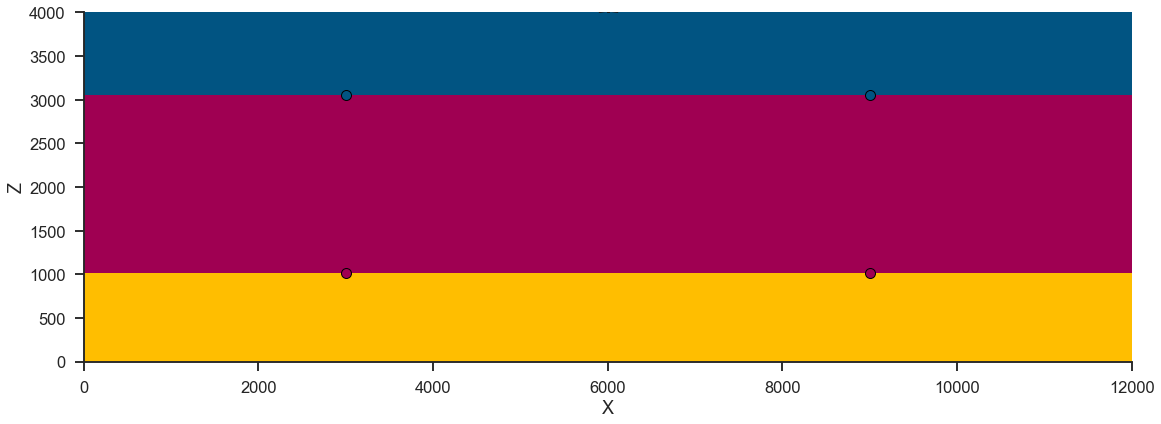

In [22]:
 gp._plot.plot_section(geo_model, 0, show_data=True, direction='y', show_topo=True)

C:\Users\Simon\Documents\git\gempy_scientific\Probabilistic Modeling\06 - Probabilistic Modeling with text\../../../gempy\gempy\plot\plot_api.py:261: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  p.fig.show()


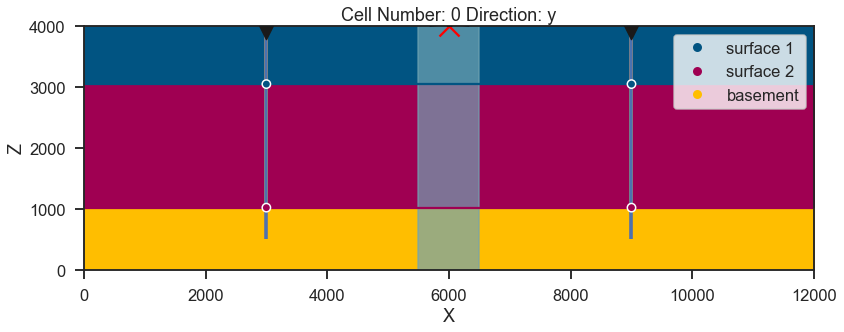

In [23]:
#p = gp._plot.plot_section(geo_model, 0, show_data=True, direction='y')
p = gp.plot_2d(geo_model, cell_number=0, show_data=True, direction='y')
p.fig.set_figwidth(20)
p.fig.axes[-1].scatter([3e3], [3.9e3],  marker='v', s =200, c='k',zorder=10)
p.fig.axes[-1].scatter([9e3], [3.9e3],  marker='v', s =200, c='k', zorder=10)
p.fig.axes[-1].scatter([6e3], [4e3],  marker='x', s =400, c='red',zorder=10)

p.fig.axes[-1].vlines(3e3, .5e3, 10e3, linewidth=4, color='gray', )
p.fig.axes[-1].vlines(9e3, .5e3, 10e3, linewidth=4, color='gray')
p.fig.axes[-1].vlines(3e3, .5e3, 10e3)
p.fig.axes[-1].vlines(9e3, .5e3, 10e3)
p.fig.axes[-1].vlines(9e3, .5e3, 10e3)
p.fig.axes[-1].fill_between(x=[5.5e3,6.5e3], y1=[0,0], y2=[10e3,10e3], alpha=.7, color=default_blue);

In [16]:
geo_model.surface_points

,X,Y,Z,smooth,surface
0,3000.0,0.0,3050.0,0.000001,surface 1
1,9000.0,0.0,3050.0,0.000001,surface 1
2,3000.0,0.0,1020.0,0.000001,surface 2
3,9000.0,0.0,1020.0,0.000001,surface 2


In [24]:
indices_bool = geo_model.surface_points.df['surface'].isin(['surface 1', 'surface 2'])
indices = geo_model.surface_points.df.index[indices_bool]
Z_init = geo_model.surface_points.df.loc[indices, 'Z'].copy()

In [25]:
import theano.tensor as tt

def sample_grav(Z_var2):
    Z_loc = np.hstack([Z_init[0] + Z_var2[0],
                       Z_init[1] + Z_var2[1],
                       Z_init[2] + Z_var2[2],
                       Z_init[3] + Z_var2[3]])


    geo_model.modify_surface_points(indices, Z=Z_loc)
    gp.compute_model(geo_model)

    # Returns the 3d lith array
    return geo_model.solutions.fw_gravity

def sample_lith(Z_var):
    Z_loc = np.hstack([Z_init[0] + Z_var[0],
                       Z_init[1] + Z_var[1],
                       Z_init[2] + Z_var[2],
                       Z_init[3] + Z_var[3]])


    geo_model.modify_surface_points(indices, Z=Z_loc)
    gp.compute_model(geo_model)

    # Returns the 3d lith array
    return geo_model.solutions.lith_block


class GemPyGrav(tt.Op):
    itypes = [tt.dvector]
    otypes = [tt.dvector]

    def perform(self, node, inputs, outputs):
        theta, = inputs
        mu = sample_grav(theta)
        outputs[0][0] = np.array(mu)

class GemPyLith(tt.Op):
    itypes = [tt.dvector]
    otypes = [tt.dvector]

    def perform(self, node, inputs, outputs):
        theta, = inputs
        mu = sample_lith(theta)
        outputs[0][0] = np.array(mu)

gempy_grav = GemPyGrav()
gempy_lith = GemPyLith()

In [26]:
g_obs_p = 1e3 * np.array([-0.3548658 , -0.35558686, -0.3563156 , -0.35558686, -0.3548658 ,
       -0.3534237 , -0.35201198, -0.3534237 , -0.3548658 , -0.3563401 ,
       -0.3548658 , -0.35558686, -0.3548658 , -0.3541554 , -0.3534569 ,
       -0.3527707 , -0.35424498, -0.35575098, -0.3572901 , -0.35575098,
       -0.35424498, -0.35575098, -0.35424498, -0.35575098, -0.35424498,
       -0.35575098, -0.35643718, -0.35713565, -0.35643718], dtype='float64')

y_obs_list = 1e3 * np.array([2.12, 2.06, 2.08, 2.05, 2.08, 2.09,
              2.19, 2.07, 2.16, 2.11, 2.13, 1.92])

In [27]:
with pm.Model() as model:
    
    Z_var = pm.Normal('depths', geo_model.surface_points.df['Z'],
                   np.array([200, 200, 200, 200]), shape=4, dtype='float64')

    grav = gempy_grav(Z_var)
    geo = gempy_lith(Z_var)

    grav = pm.Deterministic('gravity', grav[0])
    well_1 = geo.reshape((500,1,500))[125, 0 ,:]
    well_2 = geo.reshape((500,1,500))[375, 0 ,:]

    thick_1 = pm.Deterministic('thick_1', well_1.sum())
    thick_2 = pm.Deterministic('thick_2', well_2.sum())
  
    sigma_grav = pm.Normal('sigma', mu = 250, sigma = 40)
    sigma_thick = pm.Gamma('sigma_thickness', mu = 300, sigma = 300)
    sigma_thick2 = pm.Gamma('sigma2_thickness', mu = 300, sigma = 300)

    obs_grav = pm.Normal('y', mu=grav, sd=sigma_grav, observed=g_obs_p)
    obs_thick_1 = pm.Normal('y2', mu=thick_1, sd=sigma_thick, observed=y_obs_list)
    obs_thick_2 = pm.Normal('y3', mu=thick_2, sd=sigma_thick2, observed=y_obs_list)



C:\Users\Simon\Documents\git\gempy_scientific\Probabilistic Modeling\06 - Probabilistic Modeling with text\../../../gempy\gempy\core\solution.py:359: UserWarning: Surfaces not computed due to: Input array must be at least 2x2x2.. The surface is: Series: Input array must be at least 2x2x2.; Surface Number:0
  warnings.warn('Surfaces not computed due to: ' + str(
C:\Users\Simon\Documents\git\gempy_scientific\Probabilistic Modeling\06 - Probabilistic Modeling with text\../../../gempy\gempy\core\solution.py:359: UserWarning: Surfaces not computed due to: Input array must be at least 2x2x2.. The surface is: Series: Input array must be at least 2x2x2.; Surface Number:1
  warnings.warn('Surfaces not computed due to: ' + str(


In [28]:
with model:
    trace = pm.sample(50, cores=1, chains=1, step = pm.Metropolis(), tune=50)


Only 50 samples in chain.
Sequential sampling (1 chains in 1 job)
CompoundStep
>Metropolis: [sigma2_thickness]
>Metropolis: [sigma_thickness]
>Metropolis: [sigma]
>Metropolis: [depths]
Sampling chain 0, 0 divergences:   0%|                                                         | 0/100 [00:00<?, ?it/s]C:\Users\Simon\Documents\git\gempy_scientific\Probabilistic Modeling\06 - Probabilistic Modeling with text\../../../gempy\gempy\core\solution.py:359: UserWarning: Surfaces not computed due to: Input array must be at least 2x2x2.. The surface is: Series: Input array must be at least 2x2x2.; Surface Number:0
  warnings.warn('Surfaces not computed due to: ' + str(
C:\Users\Simon\Documents\git\gempy_scientific\Probabilistic Modeling\06 - Probabilistic Modeling with text\../../../gempy\gempy\core\solution.py:359: UserWarning: Surfaces not computed due to: Input array must be at least 2x2x2.. The surface is: Series: Input array must be at least 2x2x2.; Surface Number:1
  warnings.warn('Surface

In [29]:
data = az.from_pymc3(trace=trace)

C:\Users\Simon\Anaconda3\envs\gempy_mcmc_py38\lib\site-packages\arviz\data\base.py:148: UserWarning: More chains (50) than draws (4). Passed array should have shape (chains, draws, *shape)
  warnings.warn(


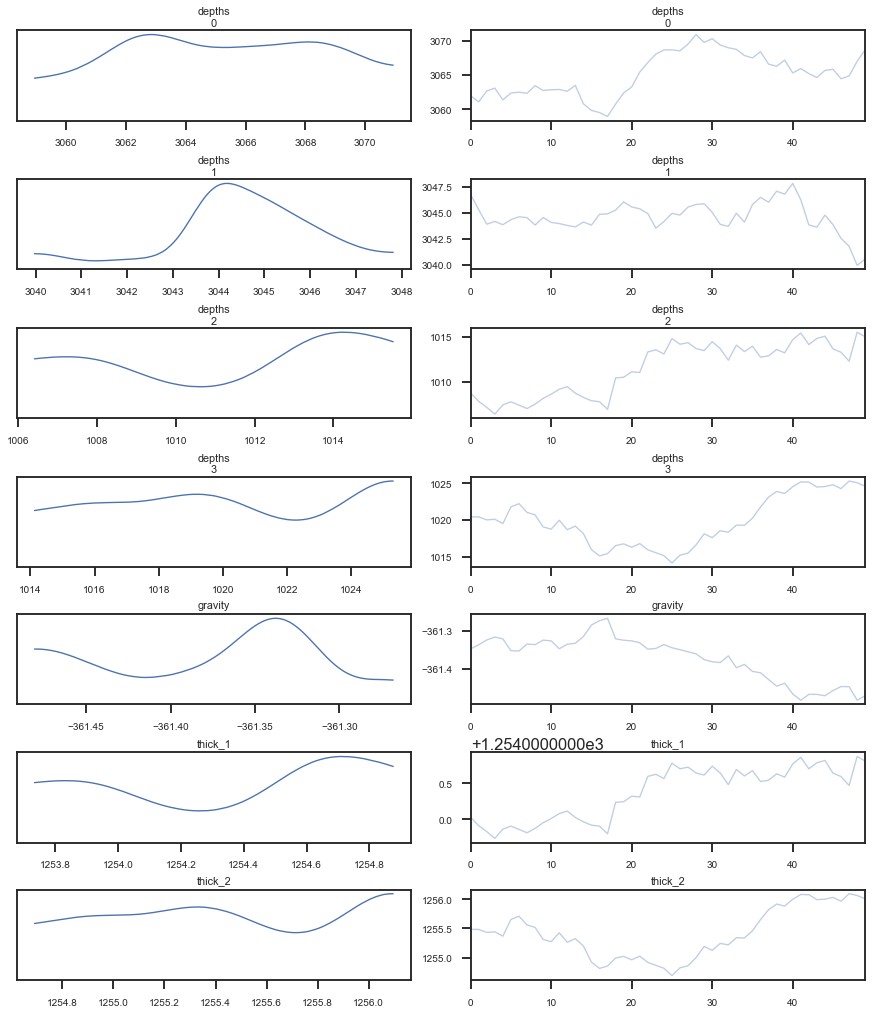

In [30]:
az.plot_trace(data, var_names=['depths', 'gravity', 'thick_1', 'thick_2']);

In [33]:
data.posterior

<xarray.Dataset>
Dimensions:           (chain: 1, draw: 100, depths_dim_0: 4)
Coordinates:
  * chain             (chain) int32 0
  * draw              (draw) int32 0 1 2 3 4 5 6 7 8 ... 92 93 94 95 96 97 98 99
  * depths_dim_0      (depths_dim_0) int32 0 1 2 3
Data variables:
    depths            (chain, draw, depths_dim_0) float32 3.057e+03 ... 1.025...
    sigma             (chain, draw) float32 248.0 247.3 246.4 ... 256.2 256.9
    gravity           (chain, draw) float32 -361.3 -361.3 ... -361.5 -361.6
    thick_1           (chain, draw) float32 1.254e+03 1.254e+03 ... 1.256e+03
    thick_2           (chain, draw) float32 1.255e+03 1.255e+03 ... 1.256e+03
    sigma_thickness   (chain, draw) float32 795.8 1.237e+03 ... 637.8 637.8
    sigma2_thickness  (chain, draw) float32 760.7 760.7 760.7 ... 928.6 928.6
Attributes:
    created_at:                 2022-04-21T10:10:51.321627
    arviz_version:              0.10.0
    inference_library:          pymc3
    inference_library_version:  3.8

In [30]:
with model:
    prior = pm.sample_prior_predictive(1000)
    post = pm.sample_posterior_predictive(trace)

C:\Users\Simon\Anaconda3\envs\gempy_mcmc_py38\lib\site-packages\theano\tensor\slinalg.py:255: LinAlgWarning: Ill-conditioned matrix (rcond=3.02432e-08): result may not be accurate.
  rval = scipy.linalg.solve(A, b)
C:\Users\Simon\Documents\git\gempy_scientific\Probabilistic Modeling\06 - Probabilistic Modeling with text\../../../gempy\gempy\core\solution.py:359: UserWarning: Surfaces not computed due to: Input array must be at least 2x2x2.. The surface is: Series: Input array must be at least 2x2x2.; Surface Number:0
  warnings.warn('Surfaces not computed due to: ' + str(
C:\Users\Simon\Documents\git\gempy_scientific\Probabilistic Modeling\06 - Probabilistic Modeling with text\../../../gempy\gempy\core\solution.py:359: UserWarning: Surfaces not computed due to: Input array must be at least 2x2x2.. The surface is: Series: Input array must be at least 2x2x2.; Surface Number:1
  warnings.warn('Surfaces not computed due to: ' + str(
C:\Users\Simon\Anaconda3\envs\gempy_mcmc_py38\lib\site-pa

-------

## References  

[1] Thomas Wiecki 2015. MCMC sampling for dummies _https://twiecki.io/blog/2015/11/10/mcmc-sampling/_ (last visited 2022-04-18)  
[2] Gallagher, K., Charvin, K., Nielsen, S., Sambridge, M., & Stephenson, J. (2009). Markov chain Monte Carlo (MCMC) sampling methods to determine optimal models, model resolution and model choice for Earth Science problems. Marine and Petroleum Geology, 26(4), 525-535.  
[3] Salvatier, J., Wiecki, T. V., & Fonnesbeck, C. (2016). Probabilistic programming in Python using PyMC3. PeerJ Computer Science, 2, e55.  


[back to top](#0)